<a href="https://colab.research.google.com/github/KalharaBatangala/BrainTumorPrediction-ResNet50/blob/main/BrainMRIAnalysis_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import torch
print('device', torch.cuda.get_device_name())
#print(torch.cuda.device_memory_used())

device Tesla T4


Image counts per class (Training):
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


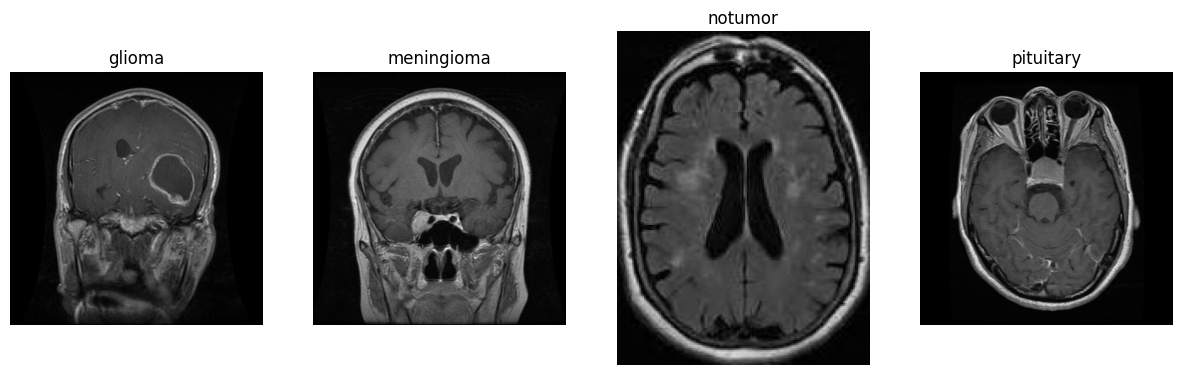

In [4]:
# data folder in google drive
data_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset/'
base_path = os.path.join(data_dir, 'Training')
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']  # 4 classes
print("Image counts per class (Training):")

for cls in classes:
    cls_path = os.path.join(base_path, cls)
    if os.path.exists(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png'))])
        print(f"{cls}: {count} images")
    else:
        print(f"{cls}: Folder not found")

# Visualize one image per class.
plt.figure(figsize=(15, 5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(base_path, cls)
    if os.path.exists(cls_path):
        img_files = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png'))]
        if img_files:
            img_path = os.path.join(cls_path, img_files[0])
            img = Image.open(img_path)
            plt.subplot(1, 4, i+1)
            plt.imshow(img, cmap='gray')  # Grayscale, assuming single-modality.
            plt.title(cls)
            plt.axis('off')
        else:
            print(f"No images found in {cls}")
plt.show()

_______________________________________________________________________
**Verify the dataset and visualizing samples**
_______________________________________________________________________

Image counts per class (Testing):
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images


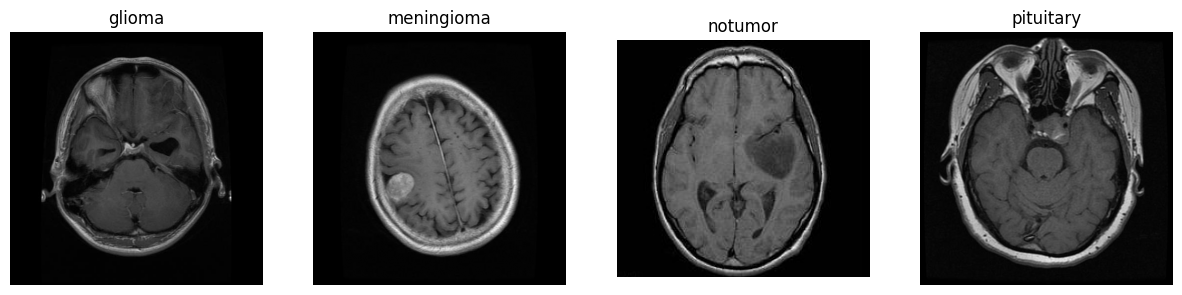

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Count images in Testing folder.
data_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset'  # Adjust if nested.
base_path = os.path.join(data_dir, 'Testing')
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Match folder names.
print("Image counts per class (Testing):")
for cls in classes:
    cls_path = os.path.join(base_path, cls)
    if os.path.exists(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png'))])
        print(f"{cls}: {count} images")
    else:
        print(f"{cls}: Folder not found")

# Visualize one image per class with contrast adjustment.
plt.figure(figsize=(15, 5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(base_path, cls)
    if os.path.exists(cls_path):
        img_files = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png'))]
        if img_files:
            img_path = os.path.join(cls_path, img_files[0])
            img = Image.open(img_path)
            img_np = np.array(img)
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)  # Normalize for contrast.
            plt.subplot(1, 4, i+1)
            plt.imshow(img_np, cmap='gray')
            plt.title(cls)
            plt.axis('off')
        else:
            print(f"No images found in {cls}")
plt.show()

_____________________________________________________
**Data preprocessing and augmentation pipeline**

_____________________________________________________

Train size: 4569 | Val size: 1143 | Test size: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


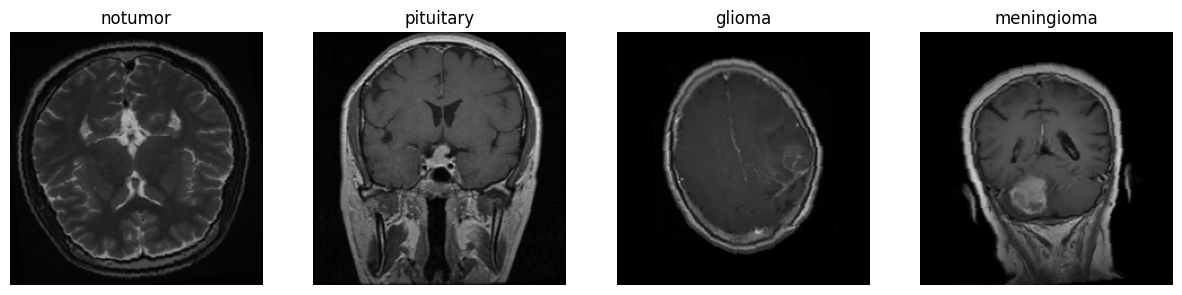

In [6]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define enhanced transforms for training (with augmentation) and val/test (minimal).
# Pros use separate transforms: augmentation for train, only preprocessing for val/test.
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet50 input size.
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip horizontally (mimics MRI orientations).
    transforms.RandomRotation(degrees=10),  # ±10° rotation (handles patient positioning).
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast (mimics scanner differences).
    transforms.ToTensor(),  # Convert to tensor (channels first).
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet norms for ResNet50.
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Same resize for consistency.
    transforms.ToTensor(),  # Convert to tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Same normalization.
])

# Load datasets with new transforms.
train_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset/Training'
test_dir = '/content/drive/MyDrive/Research/brain_tumor_dataset/Testing'

# ImageFolder for automatic labeling (0=glioma, 1=meningioma, 2=notumor, 3=pituitary).
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Split Training into train (80%) and val (20%).
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders for batching.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Verify setup.
print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.dataset.classes}")

# Visualize one batch from train_loader to check augmentation (optional, for learning).
images, labels = next(iter(train_loader))  # Get one batch.
class_names = train_dataset.dataset.classes
plt.figure(figsize=(15, 5))
for i in range(4):  # Show 4 images.
    plt.subplot(1, 4, i+1)
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to HxWxC for plotting.
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize.
    img = np.clip(img, 0, 1)  # Ensure valid pixel values.
    plt.imshow(img, cmap='gray')  # Grayscale for T2-weighted.
    plt.title(class_names[labels[i].item()])
    plt.axis('off')
plt.show()

_____________________________________________________
**Deep learning model architecture**
_____________________________________________________

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score

# Set device (GPU if available, else CPU). Pros use GPU for speed in medical imaging.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained ResNet50 (ImageNet weights).
# In medical imaging, transfer learning leverages pre-trained features for small datasets like yours (~7,000 images).
model = models.resnet50(pretrained=True)  # Loads pre-trained ResNet50.

# Freeze pre-trained layers to preserve ImageNet weights (pros fine-tune selectively for small datasets).
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer for 4 classes (glioma, meningioma, notumor, pituitary).
# ResNet50's default is 1,000 classes; we change to 4 for your task.
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final layer.

# Unfreeze final layer for fine-tuning (pros train only the new layer initially for stability).
model.fc.requires_grad = True

# Move model to GPU/CPU.
model = model.to(device)

# Define loss function (CrossEntropyLoss for multi-class; handles mild imbalance for now).
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam is common for fine-tuning in medical imaging).
# Low learning rate (0.001) preserves pre-trained weights while adapting to MRIs.
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)

# Verify model setup.
print("Final layer of ResNet50:")
print(model.fc)  # Should show: Linear(in_features=2048, out_features=4, bias=True)
print(f"Model is on device: {next(model.parameters()).device}")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


Final layer of ResNet50:
Linear(in_features=2048, out_features=4, bias=True)
Model is on device: cuda:0


In [8]:
# Define training/validation function.
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode.
    running_loss = 0.0  # keeps track of total loss for averaging later
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU.
        optimizer.zero_grad()  # Clear gradients.
        outputs = model(images)  # Forward pass: predict.
        loss = criterion(outputs, labels)  # Compute loss.
        loss.backward()  # Backpropagation.
        optimizer.step()  # Update weights.
        running_loss += loss.item() * images.size(0)  # Total loss.
        _, preds = torch.max(outputs, 1)  # Predicted classes.
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode.
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients for validation.
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

# Verify setup (no training yet).
print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.dataset.classes}")
print(f"Model final layer: {model.fc}")
print(f"Model device: {next(model.parameters()).device}")

Train size: 4569 | Val size: 1143 | Test size: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Model final layer: Linear(in_features=2048, out_features=4, bias=True)
Model device: cuda:0


_____________________________________________________
**Fine-tuning**
_____________________________________________________

In [9]:
# Unfreeze last block (layer4) for better performance
for name, param in model.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True

# Update optimizer to include unfrozen layers
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)  # Lower Lr for unfrozen layers

In [10]:
# Train for 5 epochs (pros start small to check performance).
num_epochs = 15
print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc")
for epoch in range(num_epochs):
    # Train one epoch.
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    # Validate one epoch.
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    # Print results.
    print(f"{epoch+1}    | {train_loss:.4f}    | {train_acc:.4f}  | {val_loss:.4f}  | {val_acc:.4f}")

Epoch | Train Loss | Train Acc | Val Loss | Val Acc
1    | 0.3803    | 0.8650  | 0.2024  | 0.9274
2    | 0.1970    | 0.9308  | 0.1377  | 0.9598
3    | 0.1356    | 0.9569  | 0.0886  | 0.9676
4    | 0.0955    | 0.9687  | 0.1137  | 0.9650
5    | 0.0766    | 0.9761  | 0.0748  | 0.9755
6    | 0.0556    | 0.9825  | 0.0673  | 0.9781
7    | 0.0583    | 0.9821  | 0.0666  | 0.9781
8    | 0.0544    | 0.9814  | 0.0701  | 0.9790
9    | 0.0475    | 0.9856  | 0.0687  | 0.9790
10    | 0.0374    | 0.9904  | 0.0504  | 0.9878
11    | 0.0550    | 0.9831  | 0.0626  | 0.9851
12    | 0.0243    | 0.9915  | 0.0680  | 0.9790
13    | 0.0391    | 0.9884  | 0.1247  | 0.9685
14    | 0.0613    | 0.9838  | 0.0719  | 0.9808
15    | 0.0302    | 0.9915  | 0.0829  | 0.9816


_____________________________________________________
**Testing phase**
_____________________________________________________

In [11]:
test_loss, test_acc = validate_one_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0586, Test Accuracy: 0.9825


_____________________________________________________
**Confusion matrix and classification report**
_____________________________________________________

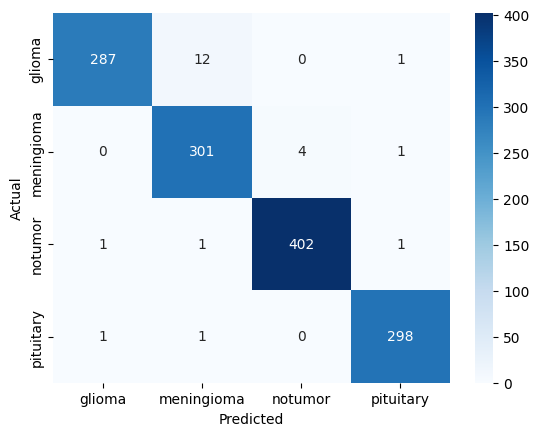

              precision    recall  f1-score   support

      glioma       0.99      0.96      0.97       300
  meningioma       0.96      0.98      0.97       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes))


_____________________________________________________
**Save the model**
_____________________________________________________

In [13]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Research/brain_tumor_model.pth')
print("Model saved to /content/drive/MyDrive/Research/brain_tumor_model.pth")

Model saved to /content/drive/MyDrive/Research/brain_tumor_model.pth


_____________________________________________________
**Explainability and insights**
_____________________________________________________

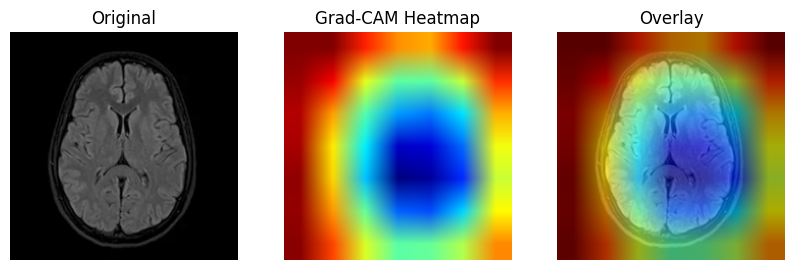

In [26]:
import torch
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# -----------------------------
# 1️⃣ Helper function to apply Grad-CAM
# -----------------------------
def generate_gradcam(model, img_tensor, target_layer_name='layer4'):
    model.eval()

    # Forward hook for activations
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations['value'] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # Register hooks
    target_layer = dict(model.named_modules())[target_layer_name]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(img_tensor)
    class_idx = torch.argmax(output, dim=1).item()

    # Backward pass for the predicted class
    model.zero_grad()
    class_score = output[0, class_idx]
    class_score.backward()

    # Grad-CAM computation
    grads = gradients['value'].mean(dim=[2, 3], keepdim=True)
    activation = activations['value']
    gradcam = torch.sum(grads * activation, dim=1).squeeze()
    gradcam = torch.relu(gradcam)
    gradcam = gradcam / torch.max(gradcam)
    gradcam = gradcam.cpu().numpy()

    return gradcam, class_idx


# -----------------------------
# 2️⃣ Choose one test image
# -----------------------------
img_path = '/content/drive/MyDrive/Research/brain_tumor_dataset/Testing/notumor/Te-noTr_0002.jpg'  # change to a real image
raw_img = Image.open(img_path).convert('RGB')

# Apply same transforms as val/test
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_tensor = transform(raw_img).unsqueeze(0).to(device)

# -----------------------------
# 3️⃣ Generate Grad-CAM
# -----------------------------
gradcam, predicted_class = generate_gradcam(model, img_tensor, target_layer_name='layer4')

# -----------------------------
# 4️⃣ Overlay on original image
# -----------------------------
heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

# Resize heatmap to the original image's size
heatmap = cv2.resize(heatmap, (224, 224)) # Resize to match original image dimensions

original = np.array(raw_img.resize((224, 224))) / 255
overlay = heatmap + original
overlay = overlay / np.max(overlay)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(original)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis('off')

plt.show()